In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from os import makedirs
from os.path import isfile, join
from pathlib import Path, PosixPath
import cv2
from shutil import copy2
from tqdm import tqdm
from tqdm.notebook import tqdm as ntqdm
from random import shuffle

from numpy.typing import ArrayLike
from typing import Any, Iterable, List, Tuple

from utils import Bbox, ImageAnnot, Segment

plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
# Read json
image_path = '../data/raw/ball/images'
js = json.load(open('../data/raw/ball/annotations.json'))

# Convert it to the input array.
img_annots = []
save_path = 'new/'

all_images = list(Path(image_path).glob('*.png')) + list(Path(image_path).glob('*.jpg'))
shuffle(all_images)

# all_images = all_images[:40].
train_size = 0.85
train_index = int(len(all_images) * train_size)

for i, image_path in enumerate(ntqdm(all_images)):
    img_annot = ImageAnnot(image_path)
    item = js[image_path.name] if image_path.name in js.keys() else None
    polygons = [item['points'] for item in item['instances'] if item['type'] == 'polygon'] if item is not None else []
    if not len(polygons):
        continue
    for ii, polygon in enumerate(polygons):
        seg = Segment(polygon, label=0)
        img_annot.add_segment(seg)

    if i < train_index:
        img_annot.save_labels(save_path=save_path, train=True, only_bboxes=False)
    else:
        img_annot.save_labels(save_path=save_path, train=False, only_bboxes=False)
    img_annots.append(img_annot)


# Generate the annotations

# Save them in specific directory

  0%|          | 0/730 [00:00<?, ?it/s]

In [3]:
train_index

620

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

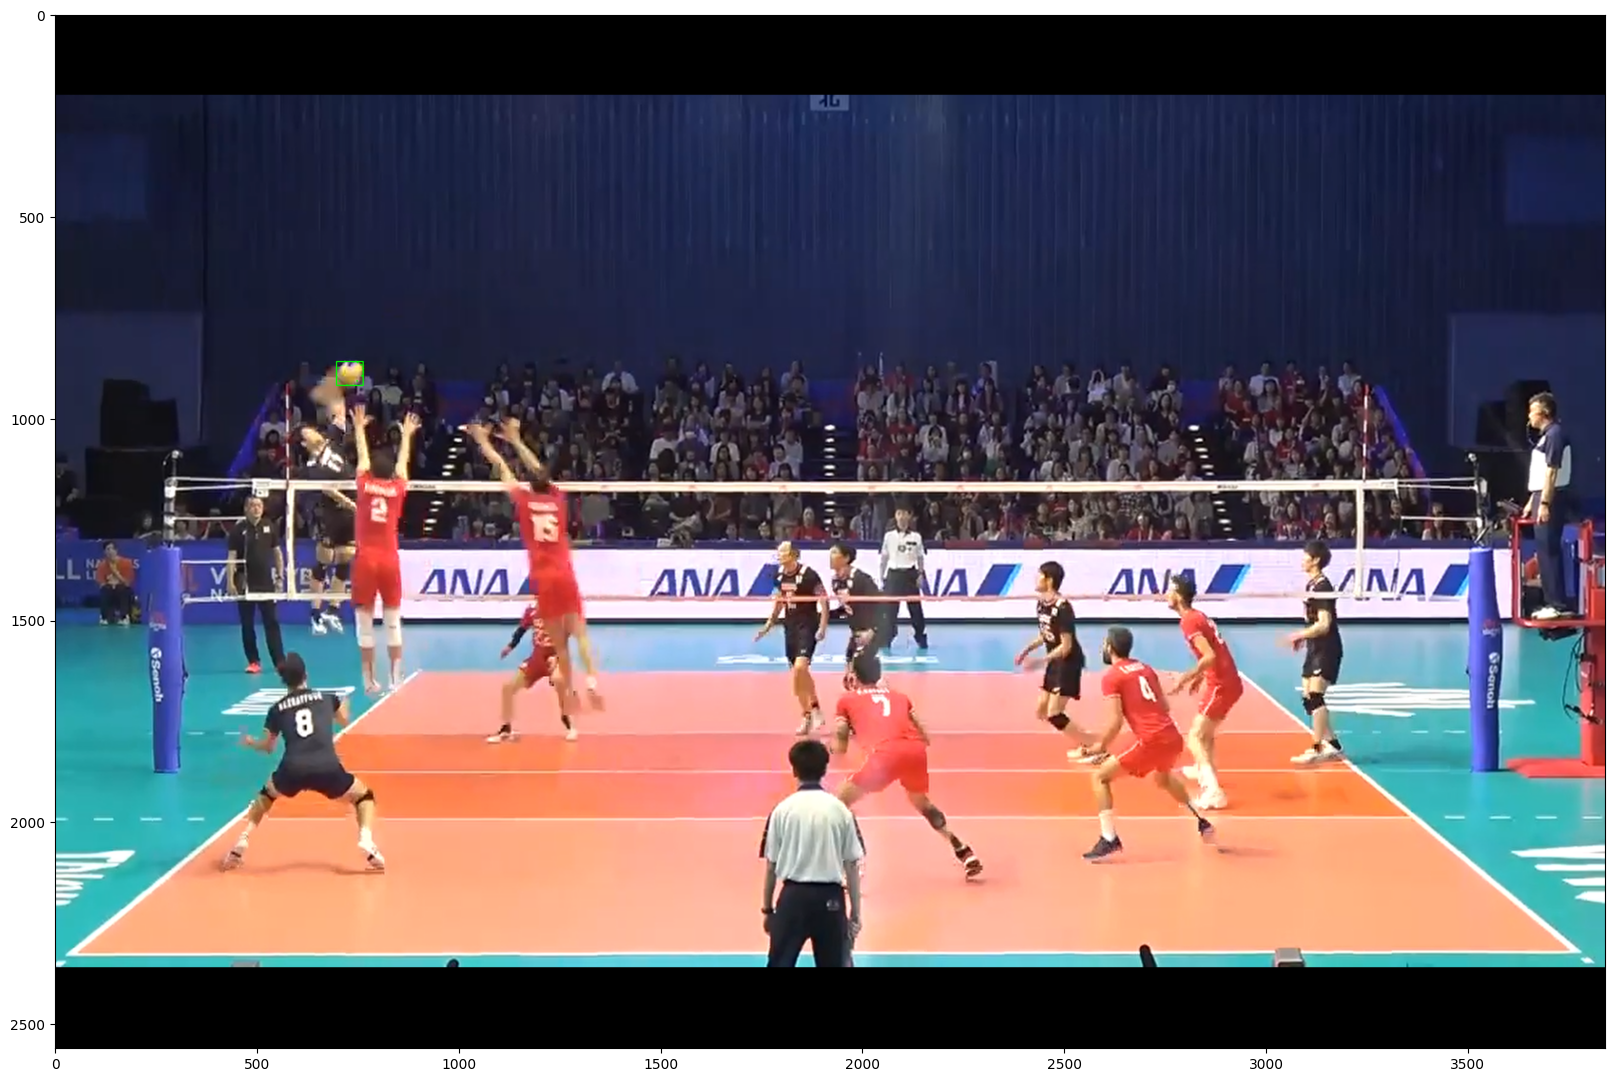

In [22]:
from random import choice
ch = choice(img_annots)
f = ch.img_show(color=(0, 255, 0))
plt.imshow(f)